In [ ]:
# Data from here:
# https://www.ecdc.europa.eu/en/publications-data/download-todays-data-geographic-distribution-covid-19-cases-worldwide
!pip install adjustText
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
from adjustText import adjust_text
from matplotlib.ticker import ScalarFormatter

# READ CUMULATIVE TABLE
covid_cumulative = pd.read_excel("covid_a_master_cumulative_table.xlsx")

## FILTER THE LAST DAY OF THE RESULTS AND PICK THE TOP N IN # OF CASES

In [ ]:
# This part is necessary instead of simply ['Date'].max() because some countries do not report on certain days (e.g. Spain on Sundays) -- FIXED BUG
last_day_per_country = covid_cumulative.groupby(['Countries'])['Date'].max() # type(last_day_per_country) is pandas.Series
last_day_per_country = last_day_per_country.to_frame() # We convert it to pandas.DataFrame
last_day_per_country.reset_index(inplace=True) # And reset the index so that we can further join on 'Countries'
last_day_per_country

,Countries,Date
0,Afghanistan,2020-08-27
1,Albania,2020-08-27
2,Algeria,2020-08-27
3,Andorra,2020-08-27
4,Angola,2020-08-27
...,...,...
205,Vietnam,2020-08-27
206,Western_Sahara,2020-08-27
207,Yemen,2020-08-27
208,Zambia,2020-08-27


In [ ]:
# N: HOW MANY TOP COUNTRIES YOU WANT TO PICK IN TERMS OF # OF CASES
N = 25
last_day = pd.merge(covid_cumulative, last_day_per_country, how='inner', left_on = ['Countries', 'Date'], right_on = ['Countries', 'Date'])
last_day = last_day.sort_values('Cases', ascending=False)
last_day
top_countries = last_day[:N]['Countries'].tolist()
top_countries

['USA',
 'Brazil',
 'India',
 'Russia',
 'S.Africa',
 'Peru',
 'Mexico',
 'Colombia',
 'Spain',
 'Chile',
 'Argentina',
 'Iran',
 'UK',
 'S.Arabia',
 'Bangladesh',
 'Pakistan',
 'Italy',
 'Turkey',
 'France',
 'Germany',
 'Iraq',
 'Philippines',
 'Indonesia',
 'Kazakhstan',
 'Canada']

## FURTHER FILTER THE TOP N COUNTRIES WITH >K CASES


In [ ]:
# K: HOW MANY CASES YOU CONSIDER THE DAY 0
K = 100
covid_top_countries = covid_cumulative[covid_cumulative.Countries.isin(top_countries)]
covid_top_countries = covid_top_countries[covid_top_countries['Cases'] > K]
covid_top_countries

,Unnamed: 0,DateRep,Country,Cases,Deaths,Date,Countries,Population,Continent
3718,3718,2020-02-24,Italy,132,2,2020-02-24,Italy,60359546.0,Europe
3785,3785,2020-02-25,Italy,229,6,2020-02-25,Italy,60359546.0,Europe
3852,3852,2020-02-26,Italy,322,11,2020-02-26,Italy,60359546.0,Europe
3915,3915,2020-02-27,Iran,139,19,2020-02-27,Iran,82913893.0,Asia
3919,3919,2020-02-27,Italy,400,12,2020-02-27,Italy,60359546.0,Europe
...,...,...,...,...,...,...,...,...,...
38863,38863,2020-08-27,S.Africa,615701,13502,2020-08-27,S.Africa,58558267.0,Africa
38864,38864,2020-08-27,S.Arabia,310836,3755,2020-08-27,S.Arabia,34268529.0,Asia
38894,38894,2020-08-27,Turkey,262507,6183,2020-08-27,Turkey,82003882.0,Asia
38897,38897,2020-08-27,UK,328846,41465,2020-08-27,UK,66647112.0,Europe


In [ ]:
# FIND THE DATE THAT THE FIRST K CASES WERE IDENTIFIED
day_0_for_every_country = covid_top_countries.groupby(['Countries'])['Date'].min()
#day_0_for_every_country = day_0_for_every_country['Date']
day_0_for_every_country

Countries
Argentina     2020-03-20
Bangladesh    2020-04-07
Brazil        2020-03-15
Canada        2020-03-12
Chile         2020-03-17
Colombia      2020-03-19
France        2020-03-02
Germany       2020-03-01
India         2020-03-17
Indonesia     2020-03-16
Iran          2020-02-27
Iraq          2020-03-16
Italy         2020-02-24
Kazakhstan    2020-03-27
Mexico        2020-03-19
Pakistan      2020-03-17
Peru          2020-03-18
Philippines   2020-03-15
Russia        2020-03-18
S.Africa      2020-03-19
S.Arabia      2020-03-16
Spain         2020-03-02
Turkey        2020-03-19
UK            2020-03-04
USA           2020-03-03
Name: Date, dtype: datetime64[ns]

In [ ]:
# MERGE THE TWO TO GET THE DAY_0 IN THE df, AND CALCULATE THE DAYS_FROM_0
covid_top_countries = covid_top_countries.merge(day_0_for_every_country, how='inner', on='Countries')
covid_top_countries.rename(columns = {'Date_y': 'Day_0'}, inplace = True)
covid_top_countries['Days_from_0'] = (covid_top_countries['Date_x'] - covid_top_countries['Day_0']).dt.days
covid_top_countries
# covid_top_countries = covid_top_countries[covid_top_countries['Days_from_0']<150]

,Unnamed: 0,DateRep,Country,Cases,Deaths,Date_x,Countries,Population,Continent,Day_0,Days_from_0
0,3718,2020-02-24,Italy,132,2,2020-02-24,Italy,60359546.0,Europe,2020-02-24,0
1,3785,2020-02-25,Italy,229,6,2020-02-25,Italy,60359546.0,Europe,2020-02-24,1
2,3852,2020-02-26,Italy,322,11,2020-02-26,Italy,60359546.0,Europe,2020-02-24,2
3,3919,2020-02-27,Italy,400,12,2020-02-27,Italy,60359546.0,Europe,2020-02-24,3
4,3986,2020-02-28,Italy,650,17,2020-02-28,Italy,60359546.0,Europe,2020-02-24,4
...,...,...,...,...,...,...,...,...,...,...,...
4176,37882,2020-08-23,Bangladesh,292625,3907,2020-08-23,Bangladesh,163046173.0,Asia,2020-04-07,138
4177,38091,2020-08-24,Bangladesh,294598,3941,2020-08-24,Bangladesh,163046173.0,Asia,2020-04-07,139
4178,38300,2020-08-25,Bangladesh,297083,3983,2020-08-25,Bangladesh,163046173.0,Asia,2020-04-07,140
4179,38509,2020-08-26,Bangladesh,299628,4028,2020-08-26,Bangladesh,163046173.0,Asia,2020-04-07,141


### CREATE THE MAX_CASES DF TO USE IT IN LABELING THE GRAPHS

In [ ]:
max_cases = covid_top_countries.groupby(by=['Countries']).max()
max_cases['Case_fatality_rate'] = max_cases['Deaths']/max_cases['Cases']*100
max_cases.sort_values('Cases', ascending=False)
max_cases['Infection_rate_per_1m'] = max_cases['Cases']/max_cases['Population']*1000000
max_cases['Mortality_rate_per_1m'] = max_cases['Deaths']/max_cases['Population']*1000000
max_cases.drop('Unnamed: 0', axis = 1, inplace = True)
max_cases.to_excel('covid_b_max_cases.xlsx')

In [ ]:
Average_infection_rate_per_1m = max_cases['Cases'].sum()/max_cases['Population'].sum()*1000000
print("The average infection rate is: {:.1f} per 1m people".format(Average_infection_rate_per_1m))
Average_death_rate_per_1m = max_cases['Deaths'].sum()/max_cases['Population'].sum()*1000000
print("The average death rate is: {:.1f} per 1m people".format(Average_death_rate_per_1m))
Average_mortality_per_cent_infected = max_cases['Deaths'].sum()/max_cases['Cases'].sum()*100
print("The average mortality rate is: {:.1f} per 100 people infected".format(Average_mortality_per_cent_infected))

The average infection rate is: 5538.8 per 1m people
The average death rate is: 194.0 per 1m people
The average mortality rate is: 3.5 per 100 people infected


In [ ]:
covid_top_countries['Cases_per_1m'] = covid_top_countries['Cases'] / covid_top_countries['Population'] * 1000000
covid_top_countries

,Unnamed: 0,DateRep,Country,Cases,Deaths,Date_x,Countries,Population,Continent,Day_0,Days_from_0,Cases_per_1m
0,3718,2020-02-24,Italy,132,2,2020-02-24,Italy,60359546.0,Europe,2020-02-24,0,2.186895
1,3785,2020-02-25,Italy,229,6,2020-02-25,Italy,60359546.0,Europe,2020-02-24,1,3.793932
2,3852,2020-02-26,Italy,322,11,2020-02-26,Italy,60359546.0,Europe,2020-02-24,2,5.334699
3,3919,2020-02-27,Italy,400,12,2020-02-27,Italy,60359546.0,Europe,2020-02-24,3,6.626955
4,3986,2020-02-28,Italy,650,17,2020-02-28,Italy,60359546.0,Europe,2020-02-24,4,10.768802
...,...,...,...,...,...,...,...,...,...,...,...,...
4176,37882,2020-08-23,Bangladesh,292625,3907,2020-08-23,Bangladesh,163046173.0,Asia,2020-04-07,138,1794.737004
4177,38091,2020-08-24,Bangladesh,294598,3941,2020-08-24,Bangladesh,163046173.0,Asia,2020-04-07,139,1806.837870
4178,38300,2020-08-25,Bangladesh,297083,3983,2020-08-25,Bangladesh,163046173.0,Asia,2020-04-07,140,1822.078952
4179,38509,2020-08-26,Bangladesh,299628,4028,2020-08-26,Bangladesh,163046173.0,Asia,2020-04-07,141,1837.688027


In [ ]:
#cases per million
max_m = covid_top_countries.groupby(by=['Countries']).max()
max_m = max_m.sort_values('Cases_per_1m', ascending=False)
max_m['Countries'] = max_m.index

data_1_5 = covid_top_countries[covid_top_countries.Countries.isin(max_m[:5]['Countries'].tolist())]
countries_1_5 = max_m[:5]['Countries'].tolist()
data_6_10 = covid_top_countries[covid_top_countries.Countries.isin(max_m[5:10]['Countries'].tolist())]
countries_6_10 = max_m[5:10]['Countries'].tolist()
data_11_15 = covid_top_countries[covid_top_countries.Countries.isin(max_m[10:15]['Countries'].tolist())]
countries_11_15 = max_m[10:15]['Countries'].tolist()
data_16_20 = covid_top_countries[covid_top_countries.Countries.isin(max_m[15:20]['Countries'].tolist())]
countries_16_20 = max_m[15:20]['Countries'].tolist()
max_m

,Unnamed: 0,DateRep,Country,Cases,Deaths,Date_x,Population,Continent,Day_0,Days_from_0,Cases_per_1m,Countries
Countries,,,,,,,,,,,,
Chile,38743,2020-08-27,Chile,402365,10990,2020-08-27,1.895204e+07,America,2020-03-17,163,21230.701611,Chile
Peru,38854,2020-08-27,Peru,613378,28124,2020-08-27,3.251046e+07,America,2020-03-18,162,18867.095768,Peru
USA,38898,2020-08-27,USA,5821876,179714,2020-08-27,3.290649e+08,America,2020-03-03,177,17692.180780,USA
Brazil,38730,2020-08-27,Brazil,3717156,117665,2020-08-27,2.110495e+08,America,2020-03-15,165,17612.719601,Brazil
Colombia,38745,2020-08-27,Colombia,572270,18184,2020-08-27,5.033944e+07,America,2020-03-19,161,11368.222727,Colombia
S.Africa,38863,2020-08-27,S.Africa,615701,13502,2020-08-27,5.855827e+07,Africa,2020-03-19,161,10514.330965,S.Africa
S.Arabia,38864,2020-08-27,S.Arabia,310836,3755,2020-08-27,3.426853e+07,Asia,2020-03-16,164,9070.596523,S.Arabia
Spain,38672,2020-08-26,Spain,419849,28971,2020-08-26,4.693706e+07,Europe,2020-03-02,177,8944.936048,Spain
Argentina,38710,2020-08-27,Argentina,370175,7839,2020-08-27,4.478068e+07,America,2020-03-20,160,8266.400629,Argentina


In [ ]:
#Code for line text
idx = covid_top_countries.groupby(['Countries'])['Days_from_0'].transform(max) == covid_top_countries['Days_from_0']
new_data3 = covid_top_countries[idx]
new_data3

,Unnamed: 0,DateRep,Country,Cases,Deaths,Date_x,Countries,Population,Continent,Day_0,Days_from_0,Cases_per_1m
185,38801,2020-08-27,Italy,262540,35458,2020-08-27,Italy,6.035955e+07,Europe,2020-02-24,185,4349.601967
368,38796,2020-08-27,Iran,363363,20901,2020-08-27,Iran,8.291389e+07,Asia,2020-02-27,182,4382.413934
548,38777,2020-08-27,Germany,237936,9285,2020-08-27,Germany,8.301921e+07,Europe,2020-03-01,179,2866.035360
727,38772,2020-08-27,France,253587,30544,2020-08-27,France,6.701288e+07,Europe,2020-03-02,178,3784.152967
905,38672,2020-08-26,Spain,419849,28971,2020-08-26,Spain,4.693706e+07,Europe,2020-03-02,177,8944.936048
1083,38898,2020-08-27,USA,5821876,179714,2020-08-27,USA,3.290649e+08,America,2020-03-03,177,17692.180780
1260,38897,2020-08-27,UK,328846,41465,2020-08-27,UK,6.664711e+07,Europe,2020-03-04,176,4934.137281
1429,38738,2020-08-27,Canada,126417,9094,2020-08-27,Canada,3.741104e+07,America,2020-03-12,168,3379.136393
1595,38730,2020-08-27,Brazil,3717156,117665,2020-08-27,Brazil,2.110495e+08,America,2020-03-15,165,17612.719601
1761,38855,2020-08-27,Philippines,202361,3137,2020-08-27,Philippines,1.081166e+08,Asia,2020-03-15,165,1871.691848


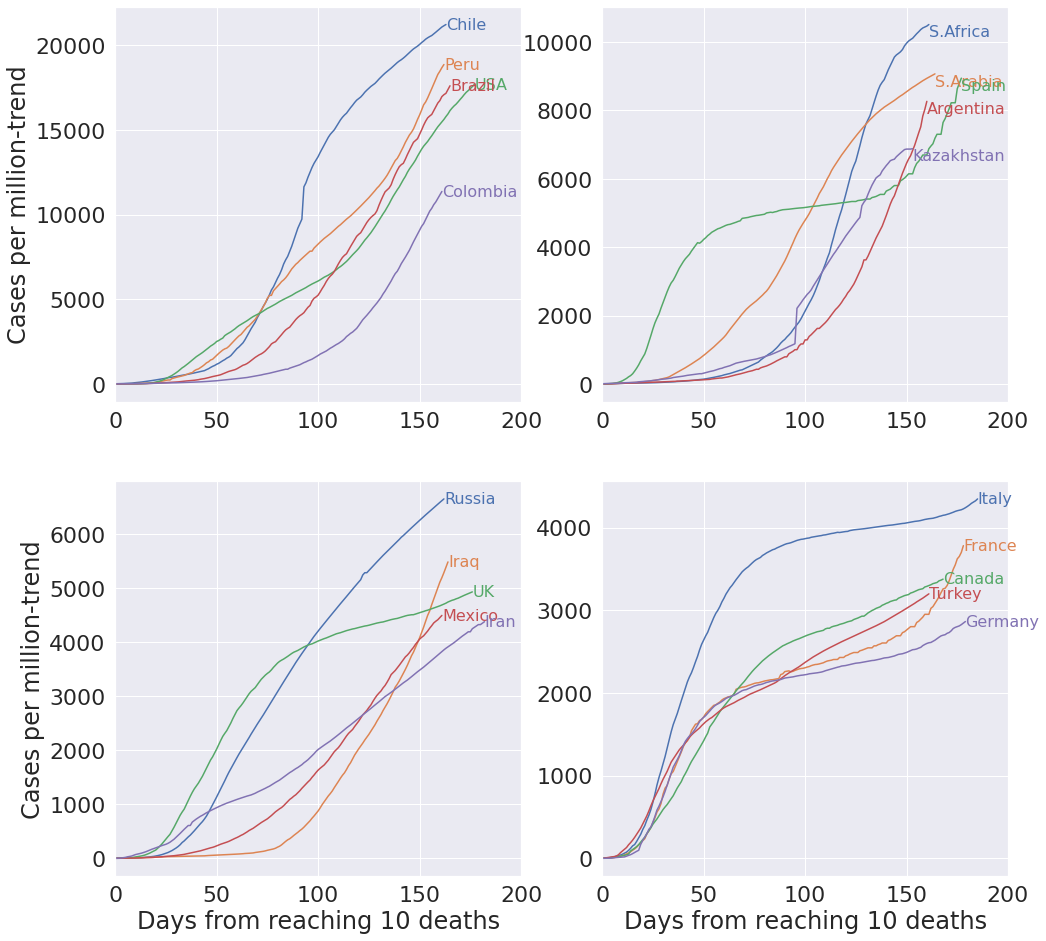

In [ ]:
sns.set(rc={'figure.figsize':(16,16)}, font_scale = 2)
fig, axes = plt.subplots(2, 2)

sns.lineplot(x="Days_from_0", y="Cases_per_1m", hue="Countries", data=data_1_5, markers=True, hue_order=countries_1_5, legend=False, ax=axes[0, 0])
texts = [axes[0, 0].text(max_m.loc[str(country)]['Days_from_0'], new_data3[new_data3['Countries'] == str(country)]['Cases_per_1m'], str(country), fontsize=16, color=axes[0, 0].get_lines()[countries_1_5.index(country)].get_c(), ha = 'left', va = 'center') for country in countries_1_5]
#adjust_text(texts)
axes[0, 0].set_ylabel("Cases per million-trend",fontsize=24)

sns.lineplot(x="Days_from_0", y="Cases_per_1m", hue="Countries", data=data_6_10, markers=True, hue_order=countries_6_10, legend=False, ax=axes[0, 1])
texts = [axes[0, 1].text(max_m.loc[str(country)]['Days_from_0'], new_data3[new_data3['Countries'] == str(country)]['Cases_per_1m'], str(country), fontsize=16, color=axes[0, 1].get_lines()[countries_6_10.index(country)].get_c(), ha = 'left', va = 'top') for country in countries_6_10]
#adjust_text(texts)

sns.lineplot(x="Days_from_0", y="Cases_per_1m", hue="Countries", data=data_11_15, markers=True, hue_order=countries_11_15, legend=False, ax=axes[1, 0])
texts = [axes[1, 0].text(max_m.loc[str(country)]['Days_from_0'], new_data3[new_data3['Countries'] == str(country)]['Cases_per_1m'], str(country), fontsize=16, color=axes[1, 0].get_lines()[countries_11_15.index(country)].get_c(), ha = 'left', va = 'center') for country in countries_11_15]
#adjust_text(texts)
axes[1, 0].set_ylabel("Cases per million-trend",fontsize=24)
axes[1, 0].set_xlabel("Days from reaching 10 deaths",fontsize=24)

sns.lineplot(x="Days_from_0", y="Cases_per_1m", hue="Countries", data=data_16_20, markers=True, hue_order=countries_16_20, legend=False, ax=axes[1, 1])
texts = [axes[1, 1].text(max_m.loc[str(country)]['Days_from_0'], new_data3[new_data3['Countries'] == str(country)]['Cases_per_1m'], str(country), fontsize=16, color=axes[1, 1].get_lines()[countries_16_20.index(country)].get_c(), ha = 'left', va = 'center') for country in countries_16_20]
#adjust_text(texts)
axes[1, 1].set_xlabel("Days from reaching 10 deaths",fontsize=24)

axes[0, 1].set_ylabel("",fontsize=24)
axes[1, 1].set_ylabel("",fontsize=24)
axes[0, 0].set_xlabel("",fontsize=24)
axes[0, 1].set_xlabel("",fontsize=24)
axes[0, 1].set_xlim([0, 200])
axes[1, 1].set_xlim([0, 200])
axes[0, 0].set_xlim([0, 200])
axes[1, 0].set_xlim([0, 200])
# axes[0, 0].set_yscale('log')
# axes[0, 1].set_yscale('log')
# axes[1, 0].set_yscale('log')
# axes[1, 1].set_yscale('log')

plt.savefig('Fig_2_1_Desai_Ashutosh.png')